In [1]:
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from utils import preprocessing

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

csv_dir = Path("norlab-data")

In [3]:
X_cols = [[k for k, v in ch.items() if v] for ch in columns.values()]
X_cols = list(chain.from_iterable(X_cols))

# Get recordings
data = preprocessing.get_recordings(csv_dir, summary)
merged = preprocessing.merge_upsample(data, summary, mode="last")

terrains = sorted(merged.terrain.unique())

X = merged[X_cols].copy()
y = merged.terrain.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [4]:
mlp_clf = MLPClassifier(max_iter=750, learning_rate="adaptive")
mlp_clf.fit(X_train, y_train)


MLPClassifier(learning_rate='adaptive', max_iter=750)

In [5]:
y_pred = mlp_clf.predict(X_test)
print(mlp_clf.score(X_test, y_test))

0.8899972814943488


Text(0.5, 1.0, 'Multi Layer Perceptron')

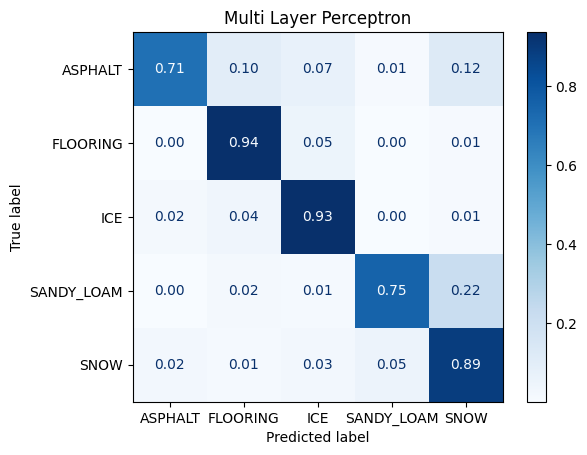

In [6]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=terrains,
    display_labels=terrains,
    normalize='true',
    values_format=".2f",
    cmap="Blues",
)
disp.ax_.set_title("Multi Layer Perceptron")

# ROC Curve

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_score = mlp_clf.predict_proba(X_test)

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'One-vs-Rest ROC')]

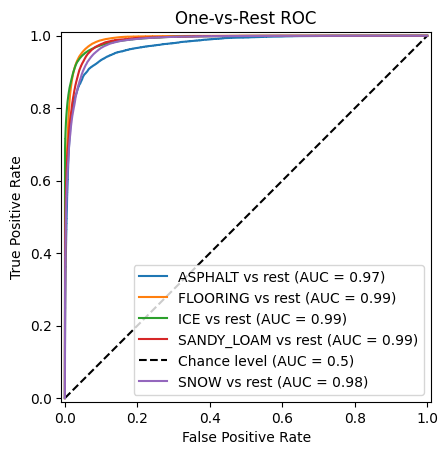

In [8]:
fig, ax = plt.subplots()
for clf_interest in terrains:
    class_id = np.flatnonzero(label_binarizer.classes_ == clf_interest)[0]
    disp = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{clf_interest} vs rest",
        plot_chance_level=(class_id==3),
        ax=ax
    )
disp.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC",
)